# LunarLander

LunarLander-v2

__Description__

+ Landing pad is always at coordinates (0,0). 

+ Coordinates are the first two numbers in state vector. 

+ Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. 
+ If lander moves away from landing pad it loses reward back. 
+ Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. 
+ Each leg ground contact is +10. 
+ Firing main engine is -0.3 points each frame. 
+ Solved is 200 points. 
+ Landing outside landing pad is possible. 
+ Fuel is infinite, so an agent can learn to fly and then land on its first attempt. 
+ Four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.


#### Imports

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from gym import wrappers, envs
import time

#### Check the various spaces.

In [2]:
env = gym.make('LunarLander-v2')
observation=env.reset()
print('action space size is',env.action_space)
print('state space size is',env.observation_space.shape)#env.observation

action space size is Discrete(4)
state space size is (8,)


#### A quick Demo

In [3]:
def demo (render=False):
    '''
    boolean - > float.
    
    Run the lunar lander game using completly random inputs and optionally show the movie.
    Returns the reward of the demo.'''
    env = gym.make('LunarLander-v2')
    TotalReward=0
    done=False
    observation=env.reset()
    while not done:
        # Render the environment to screen.
        if render:
            env.render()
        # Pause such that this loop creates a 10Hz movie of the system.
        time.sleep(0.02)
        # Choose a random action
        action=env.action_space.sample()
        # Enact the chosen action and recieve a reward.
        observation, reward, done, info = env.step(action)
        TotalReward+=reward
        if done:
            break
    env.close()
    return TotalReward

#demo(render=True)

#### Benchmark random actions

In [4]:
def benchmark(num_demos=1):
    '''
    int -> list
    
    run the demo program n times
    Return a list of scores.
    
    '''
    AllRewards=[]

    for i in range(num_demos):
        AllRewards.append(demo())
    return AllRewards

#i=20
#Runs=benchmark(i)
#print('Average reward of',i,'random runs:', sum(Runs)/len(Runs))

## DQN solution

In [5]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.make('LunarLander-v2')

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

# Turn interactive mode on.
plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using', device, 'for simulation.')

Using cpu for simulation.


In [6]:
def epsilon_threshold (steps, EPS_START = 0.9, EPS_END = 0.05, EPS_DECAY = 200):
    '''float -> float
    
    Return the probabilty of selecting exploration in a RL step.
    '''

    return min(EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps / EPS_DECAY),1.0)

def plot_eps (max_steps=1000,EPS_START = 0.9, EPS_END = 0.05, EPS_DECAY = 200):
    '''int,float,float,int -> None
    
    Plot the probability of an exploration step vs number of steps.
    
    max_steps:    Maximum number of steps to plot
    EPS_START:    Initial Probabilty at step=0
    EPS_END:      Final probability at step=infinity
    EPS_DECAY:    Sort of like a Half-life of decay in steps'''
    
    epsilon=[]
    steps=[]
    for step in range(max_steps):
        steps.append(step)
        epsilon.append(epsilon_threshold(step,EPS_START=EPS_START, EPS_END=EPS_END,EPS_DECAY=EPS_DECAY))


    fig=plt.figure()
    plt.ylim((0,1.05))
    plt.xlim((0,max_steps))
    plt.xlabel("Steps")
    plt.ylabel("Probability of exploration")
    plt.plot(steps,epsilon)
    plt.show()
    return None


'''A mapping of state-action pairs to next-state reward results'''
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):
    '''a cyclic buffer of bounded size that holds recently observed transitions.'''

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            # if we are at less than capacity, allocate fresh space for the transition
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        '''Randomly return a batch of batch_size from the memory'''
        return random.sample(self.memory, batch_size)

    def __len__(self):
        
        return len(self.memory)

In [7]:
class DQN(nn.Module):
    '''A Deep Q network for predicting actions given states'''
    def __init__(self, inputs, outputs):
        super(DQN, self).__init__()
        # inputs are the 4 vector state space
        self.FCL1 = nn.Linear(8,150)
        self.FCL2 = nn.Linear(150,120)
        self.FCL3 = nn.Linear(120,4)
        # Output is a Q value allocated to each action.
        #
        #       input    hidden   hidden  hidden  output
        #       layer    layer1   layer2  layer3  layer
        #size    8         16       64      16      4

    def forward(self, x):
        x = F.relu(self.FCL1(x))
        x = F.relu(self.FCL2(x))
        x = self.FCL3(x)
        return x

In [8]:
def select_action(state):
    '''??? -> torch
    
    Chooses an epsilon-greedy action given an input state.'''
    global steps_done
    sample = random.random()
    eps_threshold = min(EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY),1.0)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            action=policy_net(state).max(1)[1].view(1, 1)
            return action
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

def plot_durations():
    '''Show the numder of durations per episode on the yaxis.
    After 100 episodes also plot a moving average.
    '''
    plt.figure(2,figsize=(20,10)) 
    #plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        #display.display(plt.gcf())
        
def plot_reward(meanscale=10):
    '''Show the reward per episode on the yaxis.
    After 100 episodes also plot a moving average.
    '''
    plt.figure(2,figsize=(20,10)) 
    #plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(reward_values)
    # Take 100 episode averages and plot them too
    #if len(durations_t) >= meanscale:
     #   means = sum(total_reward[-meanscale:])/len(meanscale)
     #   means = torch.cat((torch.zeros(99), means))
     #   plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        #display.display(plt.gcf())

def optimize_model():
    '''
    None -> None
    
    Update the DQN policy network via SGD.
    '''
    if len(memory) < BATCH_SIZE:
        print("Warning: We do not have enough history in memory to optimize our network")
        return
    
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch 
    batch = Transition(*zip(*transitions))
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) 
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    
    # Compute V(s_{t+1}) for all next states.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    # Compute loss
    loss = F.mse_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    

    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    

#### Initialise the Learner

In [9]:
# Get number of actions from gym action space
n_actions = env.action_space.n
# Get length of state space from gym observation space
n_states = env.observation_space.shape[0]

# Create two networks
policy_net = DQN(n_states, n_actions).to(device)
target_net = DQN(n_states, n_actions).to(device)
# Duplicate the weights and biases of the policy net into the target net.
target_net.load_state_dict(policy_net.state_dict())

target_net.eval()

optimizer = optim.Adam(policy_net.parameters(),lr=0.001)
# Initialise the memory object.
memory = ReplayMemory(200000)

steps_done = 0
episode_durations = []
reward_values = []
#loss_values =[]
action_values=[]
frame_values=[]
env.close()

#### Set Learning Parameters

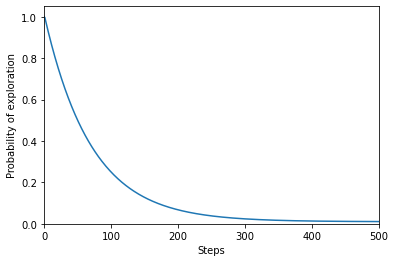

In [10]:
BATCH_SIZE = 512
# Discount Factor
GAMMA = 0.99

# Define epsilon greedy behaviour with 3 parameters.
# Note we want to explore exclusively initially.
EPS_START = 1.01
EPS_END = 0.01
EPS_DECAY = 70.0

# Plot what our epsilon values look like.
plot_eps(500,EPS_START,EPS_END,EPS_DECAY)

# How often do we update our policy network parameters (in steps)
TARGET_UPDATE = 3

Complete


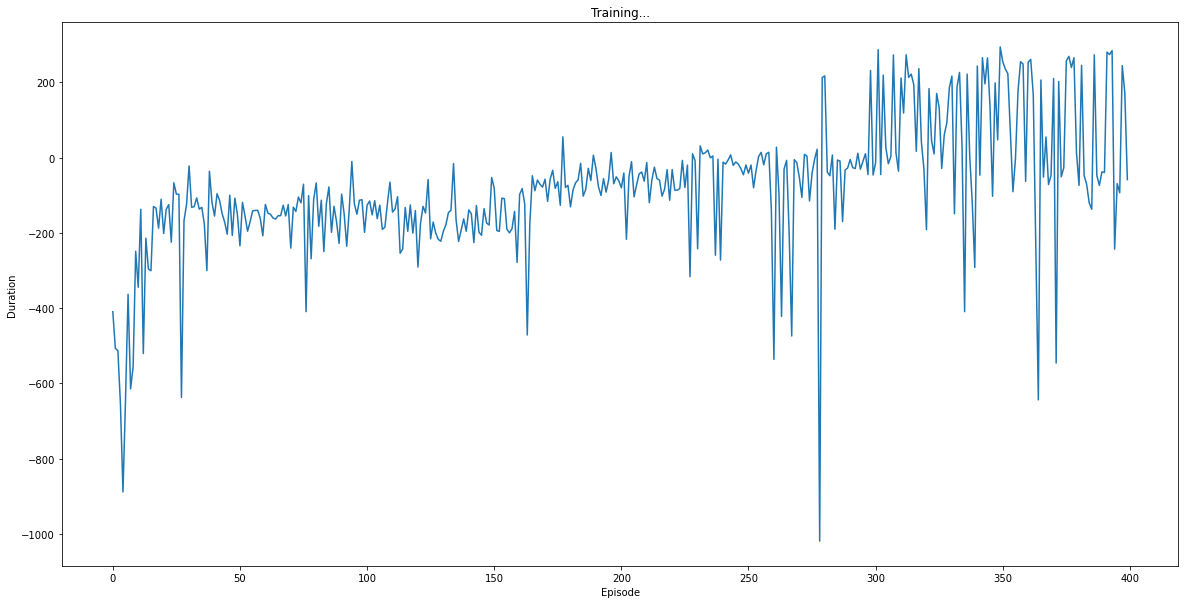

In [11]:
save_states=50
num_episodes = 400
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    TotalReward=0
    episode_frames=[]
    #episode_loss=[]
    episode_action=[]
    state, reward, done, _ = env.step(1)
    state = torch.from_numpy(np.cast['float32'](state)).unsqueeze(0).to(device)
    for t in count():
        # Select and perform an action
        action = select_action(state)
        #print(action)

        env.render()
        if i_episode % save_states == 0:
            episode_frames.append(env.render(mode = 'rgb_array'))
            episode_action.append(action.item())
            
        next_state, reward, done, _ = env.step(action.item())
        TotalReward+= reward
        next_state = torch.from_numpy(np.cast['float32'](next_state)).unsqueeze(0).to(device)
        reward = torch.tensor([reward], device=device,dtype=torch.float32)

        if not done:
            next_state = next_state
        else:
            next_state = None

        memory.push(state, action, next_state, reward)
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            reward_values.append(TotalReward)
            plot_reward()
            break
    if i_episode % save_states == 0:
        frame_values.append(episode_frames)
        #loss_values.append(episode_loss)
        action_values.append(episode_action)
        
    if i_episode % TARGET_UPDATE == 0:
        # Update the target network, copying all weights and biases in DQN
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()
plot_reward()

### Export Reward to PNG

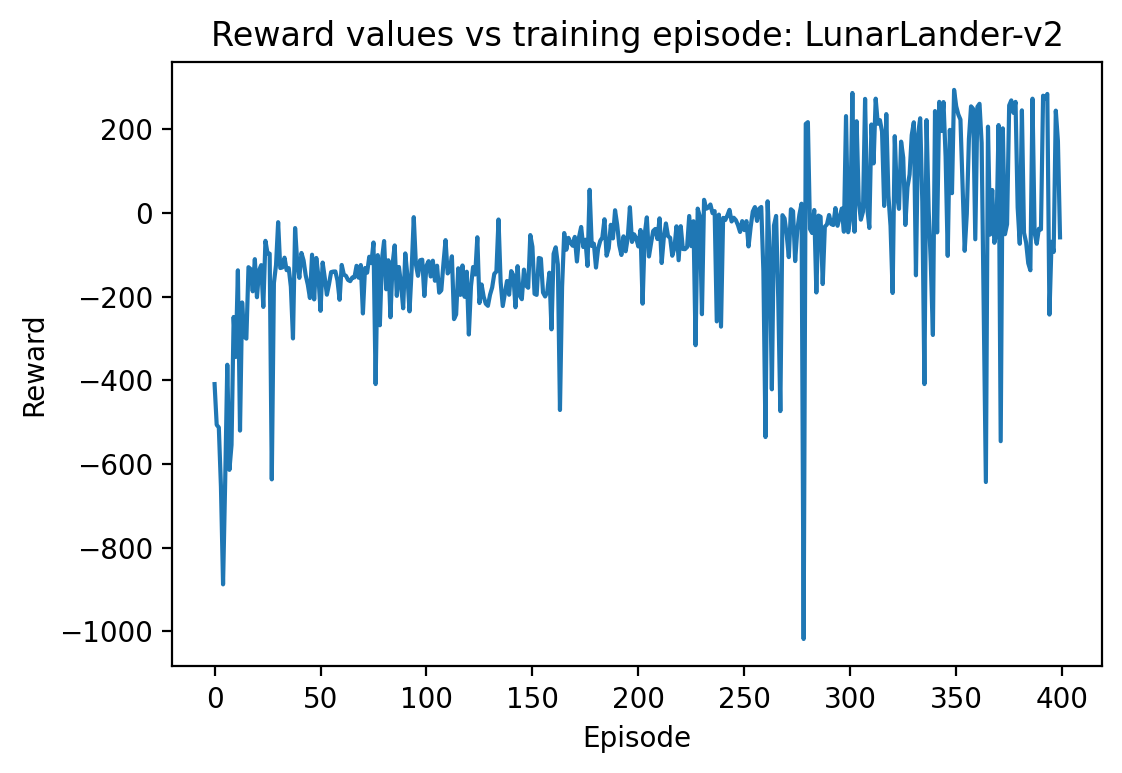

In [12]:
def save_reward():
    '''Show the reward per episode on the yaxis..
    '''
    plt.figure(2,dpi=200) 
    #plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Reward values vs training episode: LunarLander-v2')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(reward_values)
    plt.savefig('plots/LL/RewardperEp.png')

save_reward()

### Export to GIF every 50th step.

In [13]:
from array2gif import write_gif

def save_frames2gif(frame_values,save_states):
    for i in range(len(frame_values)):
        filename='LunarLander_Training_step'+str(save_states*i)+'.gif'

        write_gif(frame_values[i],'output.gif',fps=50)
        !convert output.gif -rotate 90 plots/LL/{filename}

save_frames2gif(frame_values,save_states)

convert-im6.q16: memory allocation failed `output.gif' @ error/gif.c/ReadGIFImage/1303.
convert-im6.q16: no images defined `plots/LL/LunarLander_Training_step200.gif' @ error/convert.c/ConvertImageCommand/3258.


### Plots of actions taken every 50th step.

In [14]:
def bin_actions(List_actions):
    '''List - > List
    
    Convert a list of values into a count of values.
    Used for binning actions in an episode for histogram generation
    
    >>> bin_actions([0,1,1,2,2,2,3,3,3,3])
    [1,2,3,4]'''
    
    action_ints = [0, 1, 2, 3] ## gets the unique values in the list
    histo = []
    for i in action_ints:
        if List_actions.count(i) == 0:
            histo.append(0)
        else:
            histo.append(List_actions.count(i)) ## add the number of occurances to the histo list
    return histo

In [20]:
def plot_actions(action_values,save_states):
    '''
    List -> Plot
    
    Plot binned actions taken by the agent in various time steps.'''
    plt.figure(dpi=300) 
    barWidth = 0.95/len(action_values)
    # Determine X values for the base of the bars.
    w0 = np.arange(4)
    # Determine Y values for the top of the bars.
    plt.bar(w0, bin_actions(action_values[0]), width=barWidth, label='Step 0')
    for i in range(1,len(action_values)):
        # Set position of bar on X axis
        w0 = [x + barWidth for x in w0]
        # Plot current step
        plt.bar(w0, bin_actions(action_values[i]), width=barWidth, label='Step '+str(i*save_states))

    plt.xlabel('Action')
    plt.ylabel('Count')
    plt.xticks([r + barWidth+0.3 for r in range(4)], ['Do\nNothing', 'Fire\nLeft', 'Fire\nMain', 'Fire\nRight'])

    # Create legend & Show graphic
    plt.legend()
    plt.savefig('plots/LL/ActionHistogram.png')


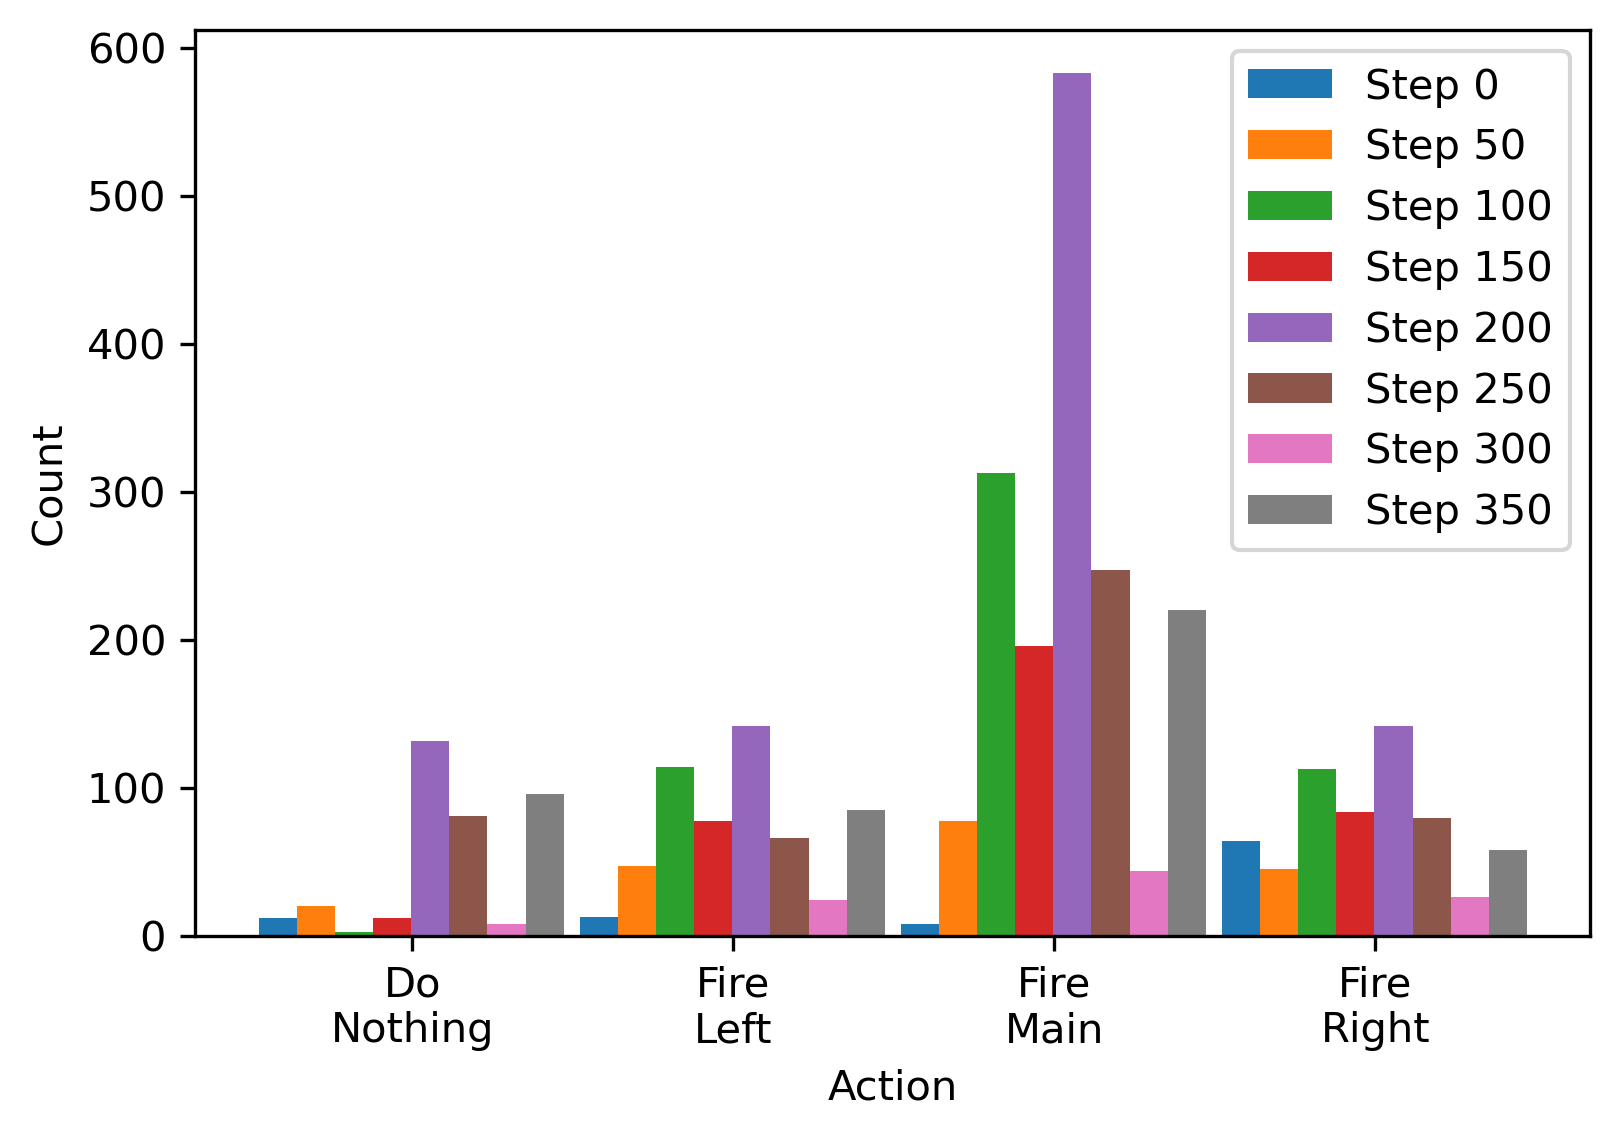

In [21]:
plot_actions(action_values,save_states)

### Save Epsilon to png

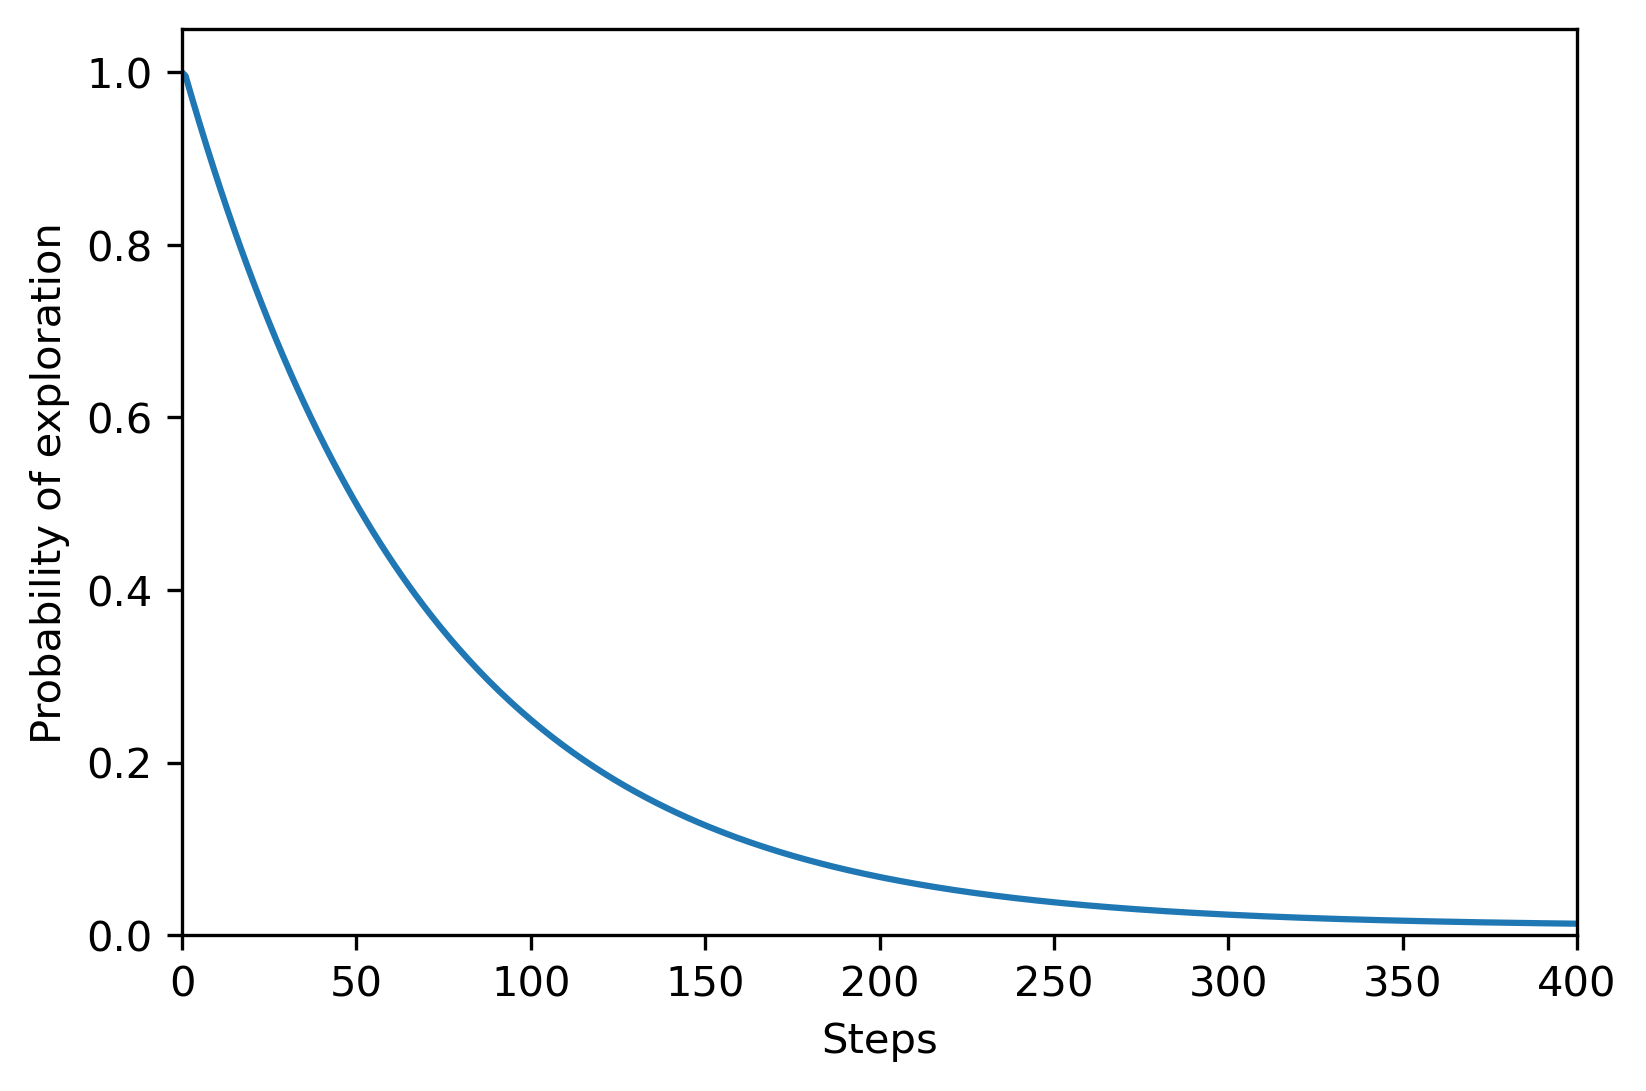

In [23]:
def plot_eps (max_steps=1000,EPS_START = 0.9, EPS_END = 0.05, EPS_DECAY = 200):
    '''int,float,float,int -> None
    
    Plot the probability of an exploration step vs number of steps.
    
    max_steps:    Maximum number of steps to plot
    EPS_START:    Initial Probabilty at step=0
    EPS_END:      Final probability at step=infinity
    EPS_DECAY:    Sort of like a Half-life of decay in steps'''
    
    epsilon=[]
    steps=[]
    for step in range(max_steps):
        steps.append(step)
        epsilon.append(epsilon_threshold(step,EPS_START=EPS_START, EPS_END=EPS_END,EPS_DECAY=EPS_DECAY))


    fig=plt.figure(dpi=300)
    plt.ylim((0,1.05))
    plt.xlim((0,max_steps))
    plt.xlabel("Steps")
    plt.ylabel("Probability of exploration")
    plt.plot(steps,epsilon)
    plt.savefig('plots/LL/epsilon.png')
    return None

plot_eps(400,EPS_START,EPS_END,EPS_DECAY)